# One more data analysis about coronavirus, but normalized...

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Functions to clean and prepare data

In [2]:
## returns a dataframe with the sum of cases for the country_str from the data source src_data
## Country/Region is the new index of this dataframe (=country_str)
def sum_cases(src_data,country_str):
    multi = src_data[src_data["Country/Region"] == country_str]
    multi = multi.groupby(multi["Country/Region"]).sum()
    return multi

## Returns a dataframe with the selected 'countries' and the 'countries_group' 
 # (countries with more than one province)  
 # Index of the returned dataframe : 'Country/Region'
def prepare_data(data,countries,countries_group):
    # Loads data from countries ignoring provinces
    data_selected = data[data["Country/Region"].isin(countries) & data["Province/State"].isnull() ]
    data_selected = data_selected.set_index('Country/Region')
    # Agregates country with provinces in the final result
    for c in countries_group:
        data_selected = pd.concat([sum_cases(data,c),data_selected])
    # deleting useless fields
    data_selected = data_selected.drop(["Province/State"],axis=1) 
    # merge data with country names
    data_selected = data_selected.join(population.set_index('Country/Region'))
    return data_selected

# Returns data normalized to convert data for 10^n inhabitants and transposed
# Deletes the field Population
def normalize_and_timeserie(data_selected,n):
    data_norm = data_selected.copy()
    data_norm["Population"] = data_norm["Population"] / 10**n
    data_norm = data_norm.div(data_norm["Population"],axis=0)
    data_norm = data_norm.drop(["Population"],axis=1)
    data_norm = data_norm.transpose()
    data_norm.index = pd.to_datetime(data_norm.index)
    return data_norm
# Basis of normalization : for 10**n inhabitants
n = 7
# Path of data
path = '../csse_covid_19_data/csse_covid_19_time_series/'

## Geography

In [3]:
# import des données de population et cohérence des formats
population = pd.read_csv(path+"population_2019.csv",header=2)
population = population[["Country Name","2018"]]
population = population.rename(columns={"2018":"Population","Country Name":"Country/Region"}) 
# synchronisation des noms de pays
population.at[249,'Country/Region']  = 'US' 
#population.head()
# Pays avec ligne principale, en ignorant provinces annexes
pays = ['France','Argentina','Chile','Italy','US','Spain','United Kingdom','Germany','Brazil']
# Ajout des pays incluant des provinces annexes
to_agregate = ['Canada','China'] 
# Filtrage des populations pour la sélection de pays
population = population[population["Country/Region"].isin(pays) | population["Country/Region"].isin(to_agregate)] 
population.head()

,Country/Region,Population
7,Argentina,4.449450e+07
27,Brazil,2.094693e+08
33,Canada,3.705886e+07
37,Chile,1.872916e+07
38,China,1.392730e+09


## Death cases

In [4]:
data = pd.read_csv(path+"time_series_covid19_deaths_global.csv")
data = data.drop(["Lat","Long"],axis=1) 
death = prepare_data(data,pays,to_agregate)
death.head()
#data.head()
#data[data["Country/Region"] == "United Kingdom"]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,17,18,26,42,56,82,131,133,171,213,...,3308,3309,3316,3322,3326,3330,3333,3335,3335,1.392730e+09
Canada,0,0,0,0,0,0,0,0,0,0,...,80,101,109,139,179,218,259,339,375,3.705886e+07
Argentina,0,0,0,0,0,0,0,0,0,0,...,23,27,28,36,39,43,44,48,56,4.449450e+07
Brazil,0,0,0,0,0,0,0,0,0,0,...,159,201,240,324,359,445,486,564,686,2.094693e+08
Chile,0,0,0,0,0,0,0,0,0,0,...,8,12,16,18,22,27,34,37,43,1.872916e+07


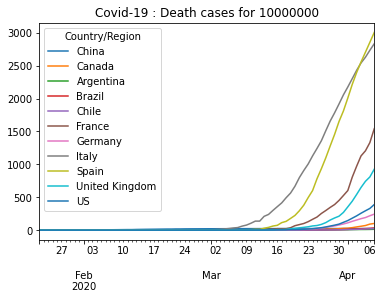

In [5]:
death_norm = normalize_and_timeserie(death,n)
title = "Covid-19 : Death cases for "+str(10**n)
death_norm.plot(title=title) 

## Confirmed cases

In [7]:
data_confirmed = pd.read_csv(path+"time_series_covid19_confirmed_global.csv")
data_confirmed = data_confirmed.drop(["Lat","Long"],axis=1) 
confirmed = prepare_data(data_confirmed,pays,to_agregate)
confirmed.head()
#data_confirmed.head()
#data_confirmed[data_confirmed['Country/Region'] == 'Canada']

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,...,82198,82279,82361,82432,82511,82543,82602,82665,82718,1.392730e+09
Canada,0,0,0,0,1,1,2,2,2,4,...,7398,8527,9560,11284,12437,12978,15756,16563,17872,3.705886e+07
Argentina,0,0,0,0,0,0,0,0,0,0,...,820,1054,1054,1133,1265,1451,1451,1554,1628,4.449450e+07
Brazil,0,0,0,0,0,0,0,0,0,0,...,4579,5717,6836,8044,9056,10360,11130,12161,14034,2.094693e+08
Chile,0,0,0,0,0,0,0,0,0,0,...,2449,2738,3031,3404,3737,4161,4471,4815,5116,1.872916e+07


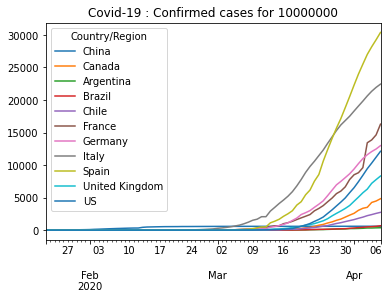

In [8]:
confirmed_norm = normalize_and_timeserie(confirmed,n)
title = "Covid-19 : Confirmed cases for "+str(10**n)
confirmed_norm.plot(title=title)

In [100]:
#from bokeh.io import output_notebook, show
#from bokeh.models import ColumnDataSource
#from bokeh.plotting import figure
#output_notebook()
#source = ColumnDataSource(confirmed_norm)
#p = figure(plot_width=500, plot_height=500, x_axis_type='datetime')
#p.circle('index', 'Chile', source=source)
#show(p)

In [101]:
#print(source.data)

## Rate death/confirmed

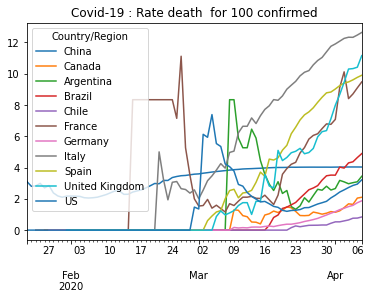

In [9]:
death_rate =  death_norm / confirmed_norm * 100
title = "Covid-19 : Rate death  for 100 confirmed"
death_rate.plot(title = title)

In [82]:
death_rate.tail()

Country/Region,China,Canada,Brazil,Chile,France,Germany,Italy,Spain,United Kingdom,US
2020-04-02,4.029988,1.231833,4.027847,0.528790,9.114288,1.305517,12.074591,9.233927,8.663029,2.434145
2020-04-03,4.030978,1.439254,3.964223,0.588708,10.113774,1.398655,12.251830,9.394374,9.445085,2.571611
2020-04-04,4.034261,1.679766,4.295367,0.648882,8.404389,1.502727,12.325887,9.469121,10.292819,2.722033
2020-04-05,4.035011,1.643818,4.366577,0.760456,8.701085,1.582054,12.320470,9.602267,10.320880,2.853693
2020-04-06,4.034356,2.046731,4.637776,0.768432,9.091929,1.750924,12.465767,9.761112,10.411177,2.941241
